# 第二题 实现3层的卷积神经网络

## 数据加载
通过pickle对原始的数据进行加载，并处理为一维的向量，可视化数据集中的图像，效果如下：

In [5]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# 数据解压，类似与字典一样的数据，通过pickle来进行解压
def load_data():
    f = gzip.open('data/mnist.pkl.gz', 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='bytes')
    f.close()
    return train_data, val_data, test_data


# 数据处理，将二维的图像数据处理成实际上我们使用的数据
def raw_data_preprocess():
    raw_train_data, raw_val_data, raw_test_data = load_data()
    # 处理训练数据
    train_inputs = [np.reshape(x, (784, 1)) for x in raw_train_data[0]]
    train_labels = [one_hot(y) for y in raw_train_data[1]]
    train_data = zip(train_inputs, train_labels)
    print("训练数据大小：{}".format(len(train_labels)))
    # 处理验证数据
    val_inputs = [np.reshape(x, (784, 1)) for x in raw_val_data[0]]
    val_labels = [one_hot(y) for y in raw_val_data[1]]
    val_data = zip(val_inputs, val_labels)
    print("验证数据大小：{}".format(len(val_labels)))
    # 处理测试数据
    test_inputs = [np.reshape(x, (784, 1)) for x in raw_test_data[0]]
    test_labels = [one_hot(y) for y in raw_test_data[1]]
    test_data = zip(test_inputs, test_labels)
    print("测试数据大小：{}".format(len(test_labels)))
    print("mnist数据加载完毕")
    return list(train_data), list(val_data), list(test_data)


# 将图片转化为onehot向量的形势
def one_hot(j):
    one_hot_j = np.zeros((10, 1))
    one_hot_j[j] = 1.0
    return one_hot_j


def show_img(img_array):
    img = Image.fromarray(img_array)
    img_gray = img.convert("L")
    # pillow 读取完的图片还是具体的整数，没有做归一化的处理
    # matplotlib做显示的时候显示的不是灰度图，是因为颜色通道的缘故
    # print(img)
    # print(np.array(img).shape)
    plt.figure("Image")
    plt.imshow(img)
    plt.axis("on")
    plt.title("mnist image")
    img_gray.save("test.jpg", quality=95, subsampling=0)
    plt.show()

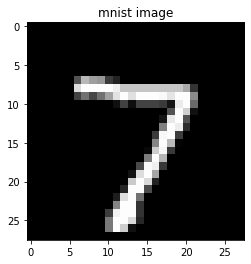

训练数据大小：50000
验证数据大小：10000
测试数据大小：10000
mnist数据加载完毕


In [6]:
train_data, val_data, test_data = load_data()
img_array = test_data[0][0]
img_28_28 = img_array.reshape(28, 28) * 255
img_28_28_int = img_28_28.astype("int")
show_img(img_28_28_int)
t,v,test = raw_data_preprocess()

## 完成mlp的搭建
按照题目要求，中间隐藏层的激活函数选择relu，输出层的激活函数为softmax，一定要注意，使用了relu作为激活函数，最后一层是不使用relu的，直接对z进行softmax即可，代码和效果如下：

In [16]:
import random
import numpy as np
from PIL import Image


def activate_function(z, name='relu'):
    if name == 'relu':
        z[z < 0] = 0
        return z
    # elif name == 'sigmoid':
    #     return 1.0 / (1.0 + np.exp(-z))


def activate_function_prime(z, name='relu'):
    if name == 'relu':
        z[z > 0] = 1
        z[z <= 0] = 0
        return z
    # elif name == 'sigmoid':
    #     return activate_function(z, "sigmoid") * (1 - activate_function(z, "sigmoid"))


def softmax(z):
    t = np.exp(z)
    a = np.nan_to_num(np.exp(z) / np.sum(t))
    return a


class Network(object):
    # sizes 用来描述网络的结构，包括输入层、隐藏层和输出层
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        # randn 用来生成标准正态分布，生成的是列向量
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        # 生成正态分布的权重矩阵，其中后面一层的结点数目为网路的左下标，前面一层的结点数目为网络的右下表，方便进行矩阵运算
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    # 执行一次前向传播, 输出的是a，根据不同的损失函数去计算损失
    def feedforward(self, a):
        # 按照课上的ppt指出，如果是最后一层，只留下z即可, 不再进行进一步的激活
        num_forward = 0
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            if num_forward < (self.num_layers - 2):
                # print("relu")
                a = activate_function(z)
            else:
                # print("softmax")
                a = softmax(z)
            num_forward = num_forward + 1
        # todo 实际上这个位置返回的应该是z，而不是a
        # y_hat = softmax(z)
        return a

    def SGD(self, train_data, epochs, mini_batch_size, eta, test_data=None):
        n = len(train_data)
        for j in range(epochs):
            random.shuffle(train_data)
            # 数据划分
            mini_batches = [train_data[k: k + mini_batch_size] for k in range(0, n, mini_batch_size)]
            # 小批量数据梯度更新
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                n_test = len(test_data)
                correct_num = self.evaluate(test_data)
                print("Epoch {} : {} / {}".format(j, correct_num, n_test))
            else:
                print("Epoch {} complete".format(j))
        # 把一个合适的权重保存下来

    def update_mini_batch(self, mini_batch, eta):
        # nabla用来表示微分，就是每一层求偏导之后的结果
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            # 把这个小批量的梯度回
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        # 终于开始梯度更新
        self.weights = [w - (eta / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # 初始化w和b的微分
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # 前向传播
        activation = x  # 一开始的那个a就是输入的x
        activations = [x]  # 保存前向传播的a，也就是激活之后的值
        zs = []  # 用来保存前向传播过程中的z，也就是累加之后的值
        current_layer = 0
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            # todo 如果是最后一层，请使用sigmoid激活函数，或者直接不整
            if current_layer < (self.num_layers - 2):
                # print("执行relu")
                activation = activate_function(z)
            else:
                # 最后一层不执行relu，仅执行sigmoid
                # print("执行softmax")
                # activation = activate_function(z, name='sigmoid')
                activation = softmax(z)
            activations.append(activation)
            current_layer = current_layer + 1

        # 开始去计算误差并进行反向传播
        # todo 反向传播的过程中，最后一层的误差其实也不去做偏导，从倒数第二层开始进行偏导
        delta = self.cost_derivative(activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        # 前面的层的误差通过后面层的误差去计算即可
        for l in range(2, self.num_layers):
            z = zs[-l]
            afp = activate_function_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * afp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return nabla_b, nabla_w

    def cost_derivative(self, out_put_activations, y, name='relu'):
        if name == "relu":
            return out_put_activations - y

    # 验证准确率
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for x, y in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def test_img(self, img_name):
        img = Image.open(img_name)
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape(784, 1)
        label_one_hot = self.feedforward(img_array)
        label = np.argmax(label_one_hot)
        print("predict: {}".format(label))

In [18]:
train_data, val_data, test_data = raw_data_preprocess()
net = Network([784, 15, 10])
net.SGD(train_data, 10, 10, 0.1, test_data)

训练数据大小：50000
验证数据大小：10000
测试数据大小：10000
mnist数据加载完毕
Epoch 0 : 8462 / 10000
Epoch 1 : 8831 / 10000
Epoch 2 : 8947 / 10000
Epoch 3 : 9012 / 10000
Epoch 4 : 9076 / 10000
Epoch 5 : 9121 / 10000
Epoch 6 : 9122 / 10000
Epoch 7 : 9158 / 10000
Epoch 8 : 9194 / 10000
Epoch 9 : 9170 / 10000


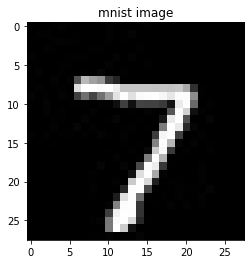

In [19]:
def show_img(imgname):
#     img = Image.open(img).convert("L")
    img = plt.imread(imgname)
    plt.figure("Image")
    plt.imshow(img,cmap ='gray')
    plt.axis("on")
    plt.title("mnist image")
    plt.show()

show_img("test.jpg")

In [20]:
net.test_img("test.jpg")

predict: 7


## 总结
整个过程比较耗时，主要还是数学基础薄弱和编程逻辑不清晰，比如最后具体的激活过程整了好久才明白，望继续加强